# Final Project
The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.


## Plan
1. Data Preprocessing: Check for missing values and duplicates, transform to correct data types and merge all datasets, add target and tenure columns.
2. EDA: Make some plots and tables to get familier with data and spot correlations, possibly find outliers and treat them.
3. Preprocessing for ML: Create features and target datasets, One-Hot encode categorical features.
4. Split: Split data to training, validation and test sets in 60-20-20 ratio.
5. Modelling: Make a dummy model for baseline score and at least 3 models in escalating complexity order, tuning the hyperparameters for each with the validation set. Continue until the validation score is good enough to expect a passing score on the test.
6. Testing: Test and score (AUC-ROC) a chosen model on the test set. If the score is 0.85 or higher, the work is done, otherwise repeat the entire process with a new split. 

## Data Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from lightgbm import LGBMClassifier, early_stopping
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

Load data.

In [2]:
contract = pd.read_csv('datasets/contract.csv', parse_dates=['BeginDate', 'EndDate'])
internet = pd.read_csv('datasets/internet.csv')
personal = pd.read_csv('datasets/personal.csv')
phone = pd.read_csv('datasets/phone.csv')
df_all = [contract, internet, personal, phone]

Overview data.

In [3]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [5]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [6]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [7]:
for df in df_all:
    print(df.info())
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non

In [8]:
for i, df in enumerate(df_all):
    print('duplicates in df{0}: {1}'.format(i, df.duplicated().sum()))

duplicates in df0: 0
duplicates in df1: 0
duplicates in df2: 0
duplicates in df3: 0


There are no missing values or duplicates. 

Make sure `customerID` is identical in `contract` and `personal`.

In [9]:
(contract['customerID'] == personal['customerID']).mean() == 1

True

Also make sure there are no unaccounted `customerID` in `phone` and `internet`.

In [10]:
phone['customerID'].isin(contract['customerID']).mean() == 1

True

In [11]:
internet['customerID'].isin(contract['customerID']).mean() == 1

True

While merging all 4 datasets, we'll create a new boolean column to indicate the client had phone subscription. There's no need to do so for internet, because we can just add a 'None' category to the existing `InternetService` column.

In [12]:
df_merged = pd.merge(personal, contract)
df_merged['Phone'] = df_merged['customerID'].isin(phone['customerID']).astype('int')
df_merged = pd.merge(df_merged, phone, how='left', on='customerID')
df_merged = pd.merge(df_merged, internet, how='left', on='customerID')
df_merged['InternetService'] = df_merged['InternetService'].fillna('None')
df_merged = df_merged.fillna('No')

Make sure there are no irregular values from typos etc. or under represented rare values.

In [13]:
for column in df_merged.columns:   
    print('{0}: {1} unique values'.format(column, df_merged[column].nunique()))
    if df_merged[column].nunique() < 10:
        print(df_merged[column].value_counts())
    print()

customerID: 7043 unique values

gender: 2 unique values
Male      3555
Female    3488
Name: gender, dtype: int64

SeniorCitizen: 2 unique values
0    5901
1    1142
Name: SeniorCitizen, dtype: int64

Partner: 2 unique values
No     3641
Yes    3402
Name: Partner, dtype: int64

Dependents: 2 unique values
No     4933
Yes    2110
Name: Dependents, dtype: int64

BeginDate: 77 unique values

EndDate: 5 unique values
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

Type: 3 unique values
Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

PaperlessBilling: 2 unique values
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

PaymentMethod: 4 unique values
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64



There are no problematic values to account for.

Add the tenure and target columns.

In [14]:
PRESENT = pd.to_datetime('2020-02-01 00:00:00')

df_merged['EndDate'] = pd.to_datetime(df_merged['EndDate'].replace({'No': PRESENT}))
df_merged['Tenure'] = (df_merged['EndDate'] - (df_merged['BeginDate'])).dt.days

# df_merged.replace({'Yes': 1, 'No': 0}, inplace=True)
df_merged['Canceled'] = (df_merged['EndDate'] < PRESENT).astype('int')

Update all 'Yes'\\'No' to boolean

In [15]:
df_merged.replace({'Yes': 1, 'No': 0}, inplace=True)

`TotalCharges` should be a number, but it cannot be converted as is because of the following items.

In [16]:
df_merged.loc[df_merged['TotalCharges'] == ' ', ['MonthlyCharges', 'BeginDate']]

,MonthlyCharges,BeginDate
488,52.55,2020-02-01
753,20.25,2020-02-01
936,80.85,2020-02-01
1082,25.75,2020-02-01
1340,56.05,2020-02-01
3331,19.85,2020-02-01
3826,25.35,2020-02-01
4380,20.00,2020-02-01
5218,19.70,2020-02-01
6670,73.35,2020-02-01


These customers just joined and haven'd even paid their first bill, so the total should be 0.

In [17]:
df_merged.loc[df_merged['TotalCharges'] == ' ', 'TotalCharges'] = 0.
df_merged['TotalCharges'] = df_merged['TotalCharges'].astype('float')

Take a look at our creation to make sure nothing went wrong

In [18]:
df_merged.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Tenure,Canceled
5864,5093-FEGLU,Female,0,1,0,2016-03-01,2020-02-01,Two year,0,Bank transfer (automatic),...,0,None,0,0,0,0,0,0,1432,0
5269,5424-RLQLC,Male,0,0,0,2019-04-01,2020-02-01,Month-to-month,1,Mailed check,...,0,DSL,0,1,0,0,1,0,306,0
4497,0575-CUQOV,Male,1,1,0,2015-02-01,2020-02-01,One year,1,Electronic check,...,0,Fiber optic,0,1,1,0,1,1,1826,0
640,9574-BOSMD,Male,0,1,1,2014-06-01,2020-02-01,Two year,0,Bank transfer (automatic),...,1,None,0,0,0,0,0,0,2071,0
3292,7284-BUYEC,Female,0,0,0,2019-09-01,2020-02-01,Month-to-month,1,Credit card (automatic),...,0,DSL,0,1,0,0,1,1,153,0


## Exploratory Data Analysis

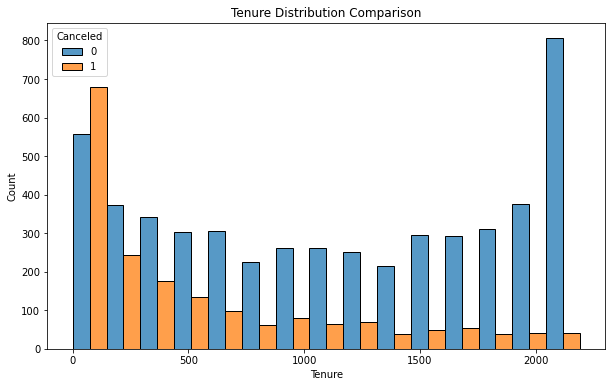

In [19]:
plt.figure(figsize=(10, 6))
plt.title('Tenure Distribution Comparison')
sns.histplot(df_merged, x='Tenure', hue='Canceled', multiple='dodge')
plt.show()

Cancelling probability drops over time.

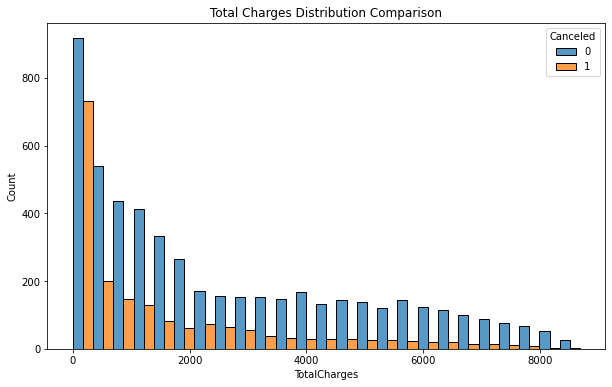

In [20]:
plt.figure(figsize=(10, 6))
plt.title('Total Charges Distribution Comparison')
sns.histplot(df_merged, x='TotalCharges', hue='Canceled', multiple='dodge')
plt.show()

Total charges are related to tenure - the longer you stay, the more you pay, so it makes sense cancelations are more common at lower total charges.

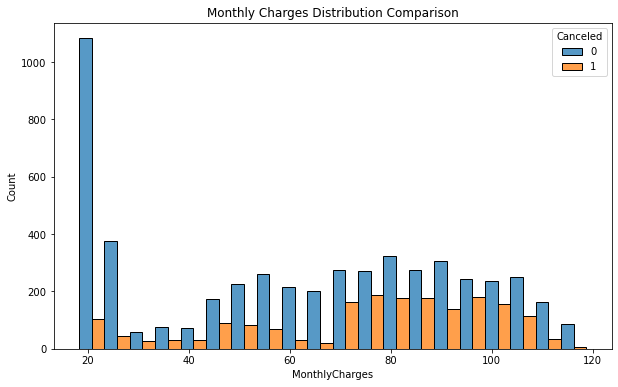

In [21]:
plt.figure(figsize=(10, 6))
plt.title('Monthly Charges Distribution Comparison')
sns.histplot(df_merged, x='MonthlyCharges', hue='Canceled', multiple='dodge', bins=20)
plt.show()

When looking at monthly charges, the proportion of cancelations is higher at the \\$70-110 range.

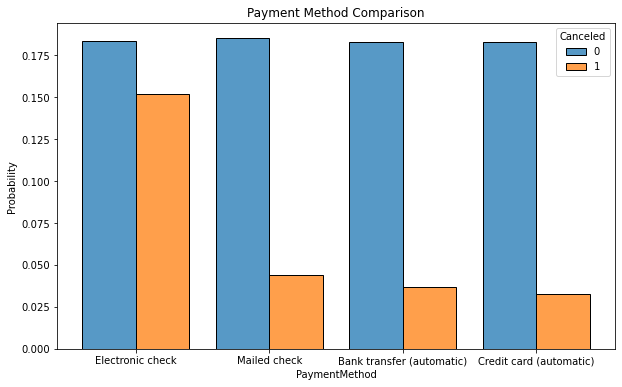

In [22]:
plt.figure(figsize=(10, 6))
plt.title('Payment Method Comparison')
sns.histplot(df_merged, x='PaymentMethod', hue='Canceled', stat='probability', multiple='dodge', shrink=0.8)
plt.show()

Customers paying by electronic check are more prone to cancelling.

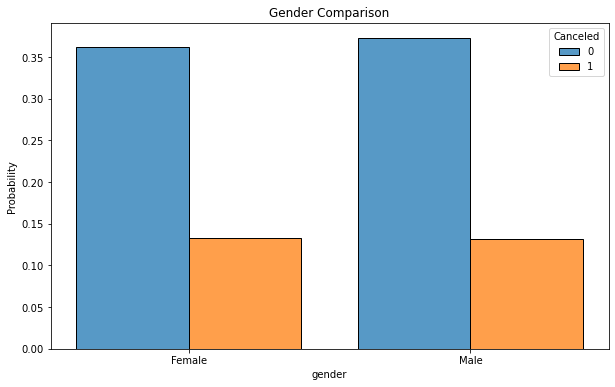

In [23]:
plt.figure(figsize=(10, 6))
plt.title('Gender Comparison')
sns.histplot(df_merged, x='gender', hue='Canceled', stat='probability', multiple='dodge', shrink=0.8)
plt.show()

No significant difference between genders.

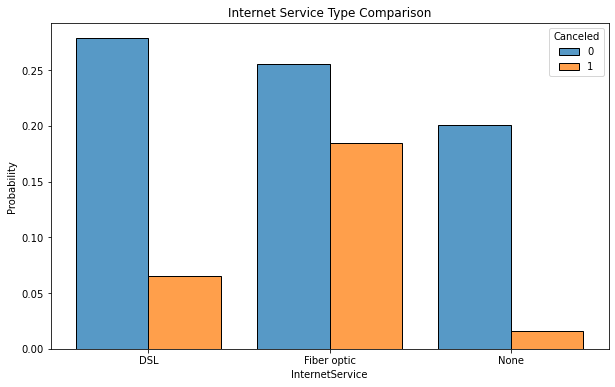

In [24]:
plt.figure(figsize=(10, 6))
plt.title('Internet Service Type Comparison')
sns.histplot(df_merged, x='InternetService', hue='Canceled', stat='probability', multiple='dodge', shrink=0.8)
plt.show()

Customers with only phone subsciption are least likely to cancel, followed by DSL users and most cancellations are from fiber users.

In [25]:
bar_cols = list(internet.columns)
bar_cols.append('Canceled')
bar_data = df_merged[bar_cols].groupby('Canceled').mean().reset_index().T.reset_index().drop(0).rename(
    columns={'index': 'service', False: 'not_canceled', True: 'canceled'})
# bar_data

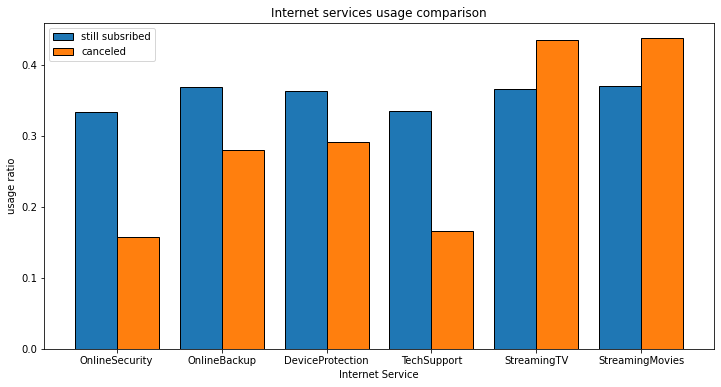

In [26]:
ind = np.arange(len(bar_data))
width = 0.4

plt.figure(figsize=(12, 6))

plt.bar(x=ind, height=bar_data['not_canceled'], width=width, ec='k', label='still subsribed')
plt.bar(x=ind+width, height=bar_data['canceled'], width=width, ec='k', label='canceled')

plt.title('Internet services usage comparison')
plt.xticks(ind + width / 2, bar_data['service'])
plt.xlabel('Internet Service')
plt.ylabel('usage ratio')
plt.legend()
plt.show()

The cancelled group was half as likely the subscibe for tech support and Online Security, but more likely to be subscribed to streaming services.

We can keep going over every feature in a similar manner, but it's redundant because the model is supposed to make all the connections on its own, as well as giving them appropriate weights, which would be hard to infer from just looking at graphs. We have showed there is some relation between the features and the target, and now it's time to start modelling.

## Preprocessing for ML
Create features and target datasets from the merged dataset. We will not use `customerID` because it holds no information, nor `BeginDate` or `EndDate` because that would be a target leakage (using `BeginDate` with `Tenure` effectively gives away the target).

In [27]:
x = df_merged.drop(['customerID', 'BeginDate', 'EndDate', 'Canceled'], axis=1)
y = df_merged['Canceled']

We need to turn the categorical features to numeric ones. We will do it with One-Hot encoding, and drop the first level because it is redundant - if there are 3 options and it's not A or B, it's necesserily C.

In [28]:
x = pd.get_dummies(x, drop_first=True)

Now that all of the features are ready, we can do the split. The train-valid-test ratio will be 6-2-2.

In [29]:
x_train, x_tmp, y_train, y_tmp = train_test_split(x, y, test_size=0.4, random_state=666)
x_valid, x_test, y_valid, y_test = train_test_split(x_tmp, y_tmp, test_size=0.5, random_state=666)
print('train-valid-test: {0}-{1}-{2}'.format(x_train.shape[0], x_valid.shape[0], x_test.shape[0]))

train-valid-test: 4225-1409-1409


## Models
We will start with scoring a dummy model to set a benchmark.

In [30]:
def print_multiscore(features, target, model):
    print('ROC-AUC: {} Accuracy: {}'.format(roc_auc_score(target, model.predict_proba(features)[:, 1]), 
                                            accuracy_score(target, model.predict(features))))
    return

In [31]:
model_dummy = DummyClassifier()
model_dummy.fit(x_train, y_train)

print_multiscore(x_valid, y_valid, model_dummy)

ROC-AUC: 0.5 Accuracy: 0.7374024130589071


Obviously it got a score of 0.5.

Next, logistic regression.

In [32]:
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(x_train, y_train)

print_multiscore(x_valid, y_valid, model_lr)

ROC-AUC: 0.8562300028613793 Accuracy: 0.8069552874378992


Already we pass the 0.85 score requirement on the validation set. But just to be sure at least one model will pass on the test set, we'll train a few more.

Dafault decision tree.

In [33]:
model_tree = DecisionTreeClassifier(random_state=123)
model_tree.fit(x_train, y_train)

print_multiscore(x_valid, y_valid, model_tree)

ROC-AUC: 0.6982545586972921 Accuracy: 0.7721788502484032


It's worse than the previous model. We'll improve it by tweaking hyperparameters.

In [34]:
best_tree = {'depth': 0, 'mss': 0, 'score': 0}

for depth in range(5, 10, 1):
    for mss in range(2, 10, 1):
        model_tree = DecisionTreeClassifier(random_state=123, max_depth=depth, min_samples_split=mss)
        model_tree.fit(x_train, y_train)
        score = roc_auc_score(y_valid, model_tree.predict_proba(x_valid)[:, 1])
        if score > best_tree['score']:
            best_tree = {'depth': depth, 'mss': mss, 'score': score}
            print(best_tree)

{'depth': 5, 'mss': 2, 'score': 0.8378742553910985}
{'depth': 6, 'mss': 2, 'score': 0.8429258902791146}
{'depth': 6, 'mss': 5, 'score': 0.8435853081185131}


In [35]:
model_tree = DecisionTreeClassifier(random_state=123, max_depth=best_tree['depth'], min_samples_split=best_tree['mss'])
model_tree.fit(x_train, y_train)

print_multiscore(x_valid, y_valid, model_tree)

ROC-AUC: 0.8435853081185131 Accuracy: 0.8026969481902059


It's better, but still not good enough. Next, a random forest.

In [36]:
best_forest = {'n': 350, 'depth': 10, 'mss': 25, 'score': 0}

# Optimization loop is commented out to save time on reruns

# for n in range(350, 450+1, 50):
#     for depth in range(10, 21, 2):
#         for mss in range(15, 26, 5):
#             model_forest = RandomForestClassifier(random_state=123, n_estimators=n, max_depth=depth, min_samples_split=mss)
#             model_forest.fit(x_train, y_train)
#             score = roc_auc_score(y_valid, model_forest.predict_proba(x_valid)[:, 1])
#             if score > best_forest['score']:
#                 best_forest = {'n': n, 'depth': depth, 'mss': mss, 'score': score}
#                 print(best_forest)

{'n': 350, 'depth': 10, 'mss': 15, 'score': 0.8663124626069767}
{'n': 350, 'depth': 10, 'mss': 20, 'score': 0.866876934682517}
{'n': 350, 'depth': 10, 'mss': 25, 'score': 0.8678966261738158}


In [37]:
model_forest = RandomForestClassifier(
    random_state=123, 
    n_estimators=best_forest['n'], 
    max_depth=best_forest['depth'], 
    min_samples_split=best_forest['mss']
)
model_forest.fit(x_train, y_train)

print_multiscore(x_valid, y_valid, model_forest)

ROC-AUC: 0.8678966261738158 Accuracy: 0.8211497515968772


This is an improvment, but we still have another tool in the box - gradient boosting. We'll train one model of each LightGBM, XGBoost and CatBoost.

In [45]:
%%time
model_lgb = LGBMClassifier(random_state=123, learning_rate=0.3, n_estimators=50, max_depth=30)
model_lgb.fit(x_train, y_train, eval_metric='auc', eval_set=[(x_valid, y_valid)], callbacks=[early_stopping(stopping_rounds=10)])
print_multiscore(x_valid, y_valid, model_lgb)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.893512	valid_0's binary_logloss: 0.343529
ROC-AUC: 0.8935124730119918 Accuracy: 0.8459900638750887
Wall time: 65.6 ms


In [44]:
%%time
model_xgb = XGBClassifier(random_state=123, eval_metric='auc', n_estimators=50, learning_rate=0.5, early_stopping_rounds=5)
model_xgb.fit(x_train, y_train, eval_set=[(x_valid, y_valid)])
print_multiscore(x_valid, y_valid, model_xgb)

[0]	validation_0-auc:0.84241
[1]	validation_0-auc:0.86540
[2]	validation_0-auc:0.87115
[3]	validation_0-auc:0.87566
[4]	validation_0-auc:0.86977
[5]	validation_0-auc:0.86980
[6]	validation_0-auc:0.87481
[7]	validation_0-auc:0.87696
[8]	validation_0-auc:0.87821
[9]	validation_0-auc:0.88678
[10]	validation_0-auc:0.88683
[11]	validation_0-auc:0.88979
[12]	validation_0-auc:0.88944
[13]	validation_0-auc:0.88843
[14]	validation_0-auc:0.89395
[15]	validation_0-auc:0.89497
[16]	validation_0-auc:0.89638
[17]	validation_0-auc:0.89577
[18]	validation_0-auc:0.90008
[19]	validation_0-auc:0.90029
[20]	validation_0-auc:0.89905
[21]	validation_0-auc:0.89871
[22]	validation_0-auc:0.89854
[23]	validation_0-auc:0.89674
[24]	validation_0-auc:0.89677
ROC-AUC: 0.9002939416798896 Accuracy: 0.8537970191625266
Wall time: 197 ms


In [43]:
%%time
model_cat = CatBoostClassifier(random_state=123, loss_function='Logloss', eval_metric='AUC', n_estimators=300, learning_rate=0.3)
model_cat.fit(
    x_train, y_train, 
    eval_set=[(x_valid, y_valid)], 
    use_best_model=True, 
    early_stopping_rounds=10,
    verbose=10,
)
print_multiscore(x_valid, y_valid, model_cat)

0:	test: 0.8218245	best: 0.8218245 (0)	total: 2.98ms	remaining: 892ms
10:	test: 0.8659262	best: 0.8670603 (8)	total: 45.1ms	remaining: 1.18s
20:	test: 0.8671826	best: 0.8679903 (12)	total: 75ms	remaining: 997ms
30:	test: 0.8770843	best: 0.8770843 (30)	total: 102ms	remaining: 888ms
40:	test: 0.8839464	best: 0.8839464 (40)	total: 129ms	remaining: 814ms
50:	test: 0.8955688	best: 0.8961905 (48)	total: 155ms	remaining: 756ms
60:	test: 0.8980348	best: 0.8980348 (60)	total: 182ms	remaining: 712ms
70:	test: 0.9003004	best: 0.9005242 (68)	total: 211ms	remaining: 681ms
80:	test: 0.9044703	best: 0.9044703 (80)	total: 239ms	remaining: 647ms
90:	test: 0.9038590	best: 0.9057163 (87)	total: 266ms	remaining: 612ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.9057162552
bestIteration = 87

Shrink model to first 88 iterations.
ROC-AUC: 0.9057162552350233 Accuracy: 0.8516678495386799
Wall time: 328 ms


## Test
The best performing model during training and validation was the CatBoost model, with validation ROC-AUC=0.9057, so it is the chosen model for the final test.

In [41]:
print_multiscore(x_test, y_test, model_cat)

ROC-AUC: 0.9063106796116503 Accuracy: 0.843860894251242


It actually did slightly better on the test set than on the validation set.

Let us marvel at our chosen model's ROC curve in all of its glory.

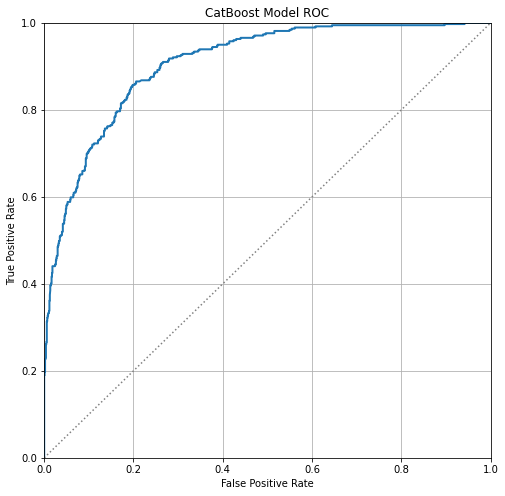

In [42]:
plt.figure(figsize=(8, 8))
plt.title('CatBoost Model ROC')
fpr, tpr, threshold = roc_curve(y_test, model_cat.predict_proba(x_test)[:, 1])
plt.plot(fpr, tpr, lw=2)
plt.plot([0, 1], [0, 1], ls=':', color='gray')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.show()